# Final project for the course "computer vision" at Poznan University of Technology
## Authors:
* Gabriela Bartoszewska
* Marcin Okonek
* Jakub Różycki

## Tutorial we used to create this project:
https://www.analyticsvidhya.com/blog/2021/01/querying-similar-images-with-tensorflow/

# Prepare folders for data
Project assumes that there is only one class in folder called class_a. We don't want to tell the model that images in our dataset are somehow related to each other. We want the model to figure it out by itself. 

In [35]:
!unzip dataset.zip
!mkdir dataset/class_a
!mv dataset/*.jpg dataset/class_a


In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Input, Dense, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pickle
import pandas as pd
from difflib import SequenceMatcher
import os

# Load images
img_height = 256
img_width = 256
channels = 3
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(
    './dataset',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'input',
     subset = 'training',
     shuffle=True)

validation_set = train_datagen.flow_from_directory(
    './dataset',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'input',
     subset = 'validation',
     shuffle=False)

Found 3791 images belonging to 1 classes.
Found 947 images belonging to 1 classes.


In [38]:
# Define the autoencoder
input_model = Input(shape=(img_height, img_width, channels))

# Encoder layers
encoder = Conv2D(32, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(encoder)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder_dim = K.int_shape(encoder)
encoder = Flatten()(encoder)

# Latent Space
latent_space = Dense(16, name='latent_space')(encoder)

# Decoder Layers
decoder = Dense(np.prod(encoder_dim[1:]))(latent_space)
decoder = Reshape((encoder_dim[1], encoder_dim[2], encoder_dim[3]))(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(32, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(3, (3, 3), padding="same")(decoder)
output = Activation('sigmoid', name='decoder')(decoder)

# Create model object
autoencoder = Model(input_model, output, name='autoencoder')

# Compile the model
autoencoder.compile(loss="mse", optimizer= Adam(learning_rate=1e-3))



In [40]:
# Fit the model
history = autoencoder.fit(
          training_set,
          steps_per_epoch=training_set.n // batch_size,
          epochs=2,
          validation_data=validation_set,
          validation_steps=validation_set.n // batch_size,
          callbacks = [ModelCheckpoint('models/image_autoencoder_2.h5', 
                                       monitor='val_loss', 
                                       verbose=0, 
                                       save_best_only=True, 
                                       save_weights_only=False)])

Epoch 1/2
236/236 [==============================] - 992s 4s/step - loss: 0.0365 - val_loss: 0.0426
Epoch 2/2
236/236 [==============================] - 973s 4s/step - loss: 0.0301 - val_loss: 0.0370


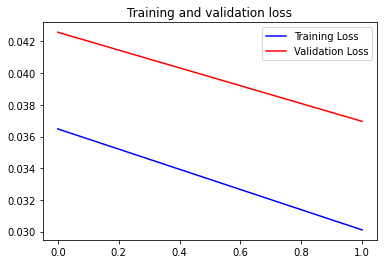

In [41]:
# Plot Accuracy and Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(loss))
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [42]:
autoencoder = load_model('models/image_autoencoder_2.h5', compile=False)

In [43]:
# Predict image function
def predict_image(image_dir, autoencoder):
  raw_image = load_img(image_dir, target_size=(256, 256))
  image = img_to_array(raw_image)
  image = np.expand_dims(image, axis=0)
  image = image / 255.0
  pred = autoencoder.predict(image)
  pred = pred * 255.0
  pred = np.reshape(pred, (256, 256, 3))
  pred = array_to_img(pred)

  return raw_image, pred

1/1 [==============================] - 0s 240ms/step


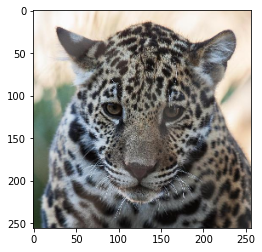

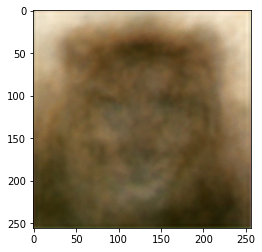

1/1 [==============================] - 0s 135ms/step


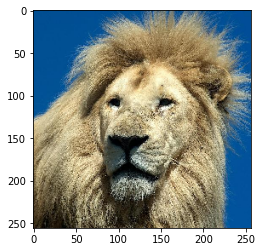

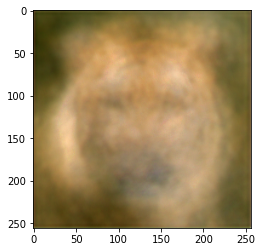

1/1 [==============================] - 0s 155ms/step


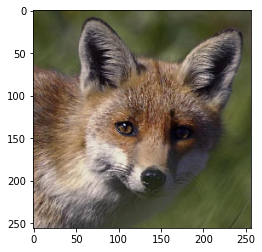

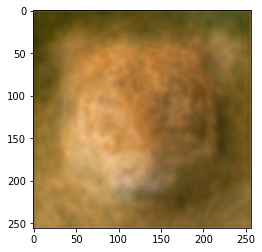

In [44]:
# Predict 3 images from training set
train_imgs = training_set.filepaths[0:3]

for i in train_imgs:
  raw_image, pred_image = predict_image(i, autoencoder)
  
  # Show original image
  plt.imshow(raw_image)
  plt.show()
  
  # Show predicted image
  plt.imshow(pred_image)
  plt.show()

1/1 [==============================] - 0s 155ms/step


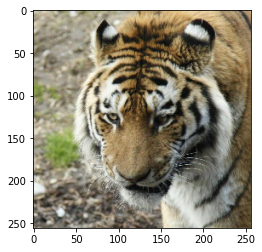

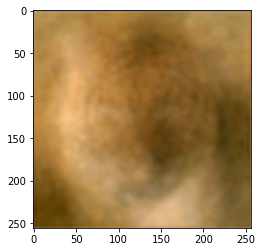

1/1 [==============================] - 0s 135ms/step


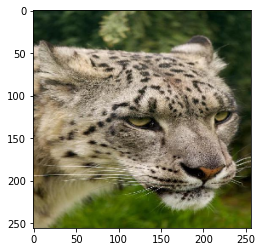

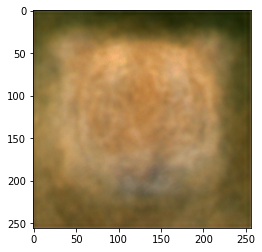

1/1 [==============================] - 0s 142ms/step


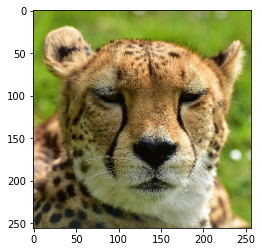

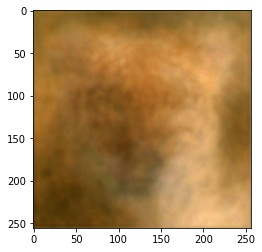

In [45]:
# Predict 3 images from validation set
val_imgs = validation_set.filepaths[0:3]

for i in val_imgs:
  raw_image, pred_image = predict_image(i, autoencoder)
  
  # Show original image
  plt.imshow(raw_image)
  plt.show()
  
  # Show predicted image
  plt.imshow(pred_image)
  plt.show()


In [46]:
# Create model with latent space layer
autoencoder = load_model('models/image_autoencoder_2.h5', compile=False)
latent_space_model = Model(autoencoder.input, autoencoder.get_layer('latent_space').output)

In [ ]:
# Load all images and predict them with the latent space model
X = []
indices = []

for i in range(len(os.listdir('./dataset/class_a'))):
  try:
    img_name = os.listdir('./dataset/class_a')[i]
    img = load_img('./dataset/class_a/{}'.format(img_name), target_size = (256, 256))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    pred = latent_space_model.predict(img)
    pred = np.resize(pred, (16))
    X.append(pred)
    indices.append(img_name)

    # Export the embeddings
    if i in [1,10,100,500,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,12000,13000,14000,15000,16000,17000,18000,19000]:
      embeddings = {'indices': indices, 'features': np.array(X)}

      pickle.dump(embeddings, open('./dataset/image_embeddings_2.pickle', 'wb'))

  except:
    print(img_name)

In [48]:
# Export the embeddings
embeddings = {'indices': indices, 'features': np.array(X)}

pickle.dump(embeddings, open('./dataset/image_embeddings_2.pickle', 'wb'))

In [49]:
def eucledian_distance(x,y):
  eucl_dist = np.linalg.norm(x - y)
  return eucl_dist

def category_similarity(x,y):
  return SequenceMatcher(None, x, y).ratio()

In [50]:
# Load embeddings
embeddings = pickle.load(open('./dataset/image_embeddings_2.pickle', 'rb'))
# Load images metadata
# metadata = pd.read_csv('flipkart/metadata.csv')

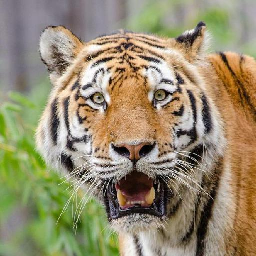

In [51]:
# Get image name
img_name = os.listdir('./dataset/class_a/')[3]
img = load_img('./dataset/class_a/{}'.format(img_name), target_size=(256, 256))
img

In [52]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
import pandas as pd

In [53]:
!mkdir dataset/features

In [ ]:
class FeatureExtractor:
    def __init__(self):
        # Use VGG-16 as the architecture and ImageNet for the weight
        base_model = VGG16(weights='imagenet')
        # Customize the model to return features from fully-connected layer
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
    def extract(self, img):
        # Resize the image
        img = img.resize((224, 224))
        # Convert the image color space
        img = img.convert('RGB')
        # Reformat the image
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        # Extract Features
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)

fe = FeatureExtractor()

# Iterate through images
for img_path in os.listdir("dataset/class_a"):
    # Extract Features
    feature = fe.extract(img=Image.open('dataset/class_a/' + str(img_path)))
    # Save the Numpy array (.npy) on designated path
    feature_path = "dataset/features/{}.npy".format(str(img_path).replace('.jpg',''))
    np.save(feature_path, feature)

In [56]:


# Build features DataFrame
features = []
for f in os.listdir("dataset/features"):
  add_feature = np.load("dataset/features/" + str(f))
  add_feature = pd.DataFrame([add_feature])
  add_feature['image'] = f.replace('.npy','.jpg')

  features.append(add_feature)

features = pd.concat(features, axis=0)
features.to_csv('dataset/feature_extraction.csv', index=False)



In [58]:
def showSimilar(img_name, n=5):
    try:
        img = Image.open("dataset/class_a/" + img_name+".jpg")
    except:
        print("Image not found")
        return

    query = fe.extract(img)

    features_data = features.copy()
    features_data = features_data.drop(columns = ['image'])
    features_data = features_data.values
    dists = np.linalg.norm(features_data - query, axis=1)

    ids = np.argsort(dists)[:n]
    lookalike_imgs = features.iloc[ids,:]['image']
    scores = pd.DataFrame({'image': lookalike_imgs,
                            'score': dists[ids]})
    scores = scores.reset_index(drop=True)

    axes=[]
    fig=plt.figure(figsize=(8,8))
    for a in range(n):
        score = scores['score'][a]
        axes.append(fig.add_subplot(n, 1, a+1))
        subplot_title=str(scores['image'][a])
        axes[-1].set_title(subplot_title)  
        plt.axis('off')
        plt.imshow(Image.open('dataset/class_a/' + scores['image'][a]))
    fig.tight_layout()
    plt.show()


1/1 [==============================] - 0s 87ms/step


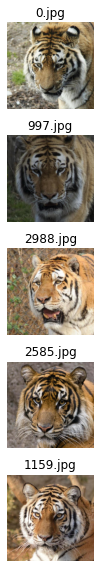

In [60]:
showSimilar('0')